In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import json

import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import bambi as bmb
print(f"Running on bmb v{bmb.__version__}")
import arviz as az
az.style.use("arviz-darkgrid") # make e.g. forestplot use a grid

# custom scripts
import dataLoader
from buttler import *

with open("./settings.json") as f:
    settings = json.load(f)


Running on PyMC v5.6.1
Running on bmb v0.12.0


## 0. Load and Pre-process Data

In [2]:
# %%capture --no-display --no-stdout
# data loading and pre-processing
df, SESSION_IDS = dataLoader.loadCausalityData()
df = dataLoader.shiftColumns(df, ["causality_judgement", "time", "angle"], SESSION_IDS)

# add columns that count sequences of 'causa'/'non-causal' responses
df = df.groupby(SESSION_IDS, group_keys=False).apply(countResponses)
# display(df.head(3))

# select and rename needed columns
data = df [["subject_id", "baseline_stimulation", "stimulation", "group", "causality_judgement1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "causality_judgement", "RT", "RT_corrected_for_delay"]]
data.columns = ["subj", "base_stim", "stim", "group", "c1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "c", "rt", "rt_c"]

DATA_SESSION_IDS = ['subj', 'base_stim', 'stim', 'group']

# name categorical values
data.loc[:, "group"] = data.loc[:, "group"].replace({0: "HC", 1: "SZ"})
# data["group"] = data["group"].replace({0: "HC", 1: "SZ"}) # Has same effect and throws same error as above...
data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})
data.head(3)

Causality data shape: (42966, 10)
Shifted Data shape: (42526, 13)


C:\Users\key\AppData\Local\Temp\ipykernel_20532\380323668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
C:\Users\key\AppData\Local\Temp\ipykernel_20532\380323668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})


subj  base_stim  stim group          c1  time  time1  angle  angle1  \
id                                                                        
1    2.0        1.0   1.0    HC      causal   0.0    4.0   30.0    22.5   
2    2.0        1.0   1.0    HC      causal  16.0    0.0   22.5    30.0   
3    2.0        1.0   1.0    HC  non_causal   0.0   16.0    0.0    22.5   

    c_seq  nc_seq           c      rt     rt_c  
id                                              
1       1       0      causal  1480.6  1480.60  
2       2       0  non_causal  1615.0  1348.44  
3       0       1      causal  1395.2  1395.20

In [3]:
# drop outlying participants
print(f"percentage of 'causal' responses for subj 16: { data[data['subj'] == 16].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")
print(f"percentage of 'causal' responses for subj 104: { data[data['subj'] == 104].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")

data = data[data["subj"] != 16]
data = data[data["subj"] != 104]

percentage of 'causal' responses for subj 16: 0.9830633284241531
percentage of 'causal' responses for subj 104: 1.0


In [4]:
# cap too long reaction time
# rt_limit = data["rt"].mean() + 4 * data["rt"].std() # = 3972.09 ms
rt_limit = 10000

print(f"Cutting off response time of {data[data['rt'] >= rt_limit].shape[0]} trials.")
print(f"This translates to {round((data[data['rt'] >= rt_limit].shape[0] / data.shape[0]) * 100, 2)} % of all trials.")

rt_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_idx, "rt"] = rt_limit

rt_c_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_c_idx, "rt_c"] = rt_limit

Cutting off response time of 14 trials.
This translates to 0.03 % of all trials.


In [5]:
# standardize data
for col in ["angle", "angle1", "time", "time1"]:
    data[col + "_std"] = standardize(data[col])

# normalize data
data = data.groupby(["subj"], group_keys=False).apply(normalize, ["rt", "rt_c", "angle", "time", "angle1", "time1"])
data.columns

Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'time', 'time1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'time_std', 'time1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'time_norm', 'angle1_norm', 'time1_norm'],
      dtype='object')

In [6]:
# nest data
nested_model_data, new_cols_c1 = nestPredictors(data, "c1", "group", drop_inner=False)
nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_std", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_std", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_norm", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_norm", "group", drop_inner=False)

def split_tDCS(group:pd.DataFrame) -> pd.DataFrame:
    stim = group["stim"].iloc[0]
    group["tDCS_" + str(int(stim))] = group["base_stim"] == 2
    return group

nested_model_data = nested_model_data.groupby(["stim"], group_keys=False).apply(split_tDCS)

def apply_tDCS_contrasts(data:pd.DataFrame) -> pd.DataFrame:
    data2 = data.copy()
    constrasts = {
        True: 1,
        False: -1,
        np.NaN: 0
    }
    columns = ["tDCS_" + str(i+1) for i in range(7)]

    data2[columns] = data2[columns].replace(constrasts)
    return data2

nested_model_data = applyCustomConstrasts(nested_model_data, columns=["c1", "group", "c1_HC", "c1_SZ"], kind="Sum")
nested_model_data = apply_tDCS_contrasts(nested_model_data)

# custom nesting for last trial properties
nested_model_data["time1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["time1_norm"]
nested_model_data["time1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["time1_norm"]
nested_model_data["angle1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["angle1_norm"]
nested_model_data["angle1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["angle1_norm"]

display(nested_model_data.head(2))
print(f"We now have available the following predictors/ columns:\n{nested_model_data.columns}")

subj  base_stim  stim  group  c1  time  time1  angle  angle1  c_seq  ...  \
id                                                                       ...   
1    2.0        1.0   1.0     -1   1   0.0    4.0   30.0    22.5      1  ...   
2    2.0        1.0   1.0     -1   1  16.0    0.0   22.5    30.0      2  ...   

    tDCS_2 tDCS_3  tDCS_4  tDCS_5  tDCS_6  tDCS_7  time1_norm_HC  \
id                                                                 
1      0.0    0.0     0.0     0.0     0.0     0.0      -0.547538   
2      0.0    0.0     0.0     0.0     0.0     0.0      -1.312343   

    time1_norm_SZ  angle1_norm_HC  angle1_norm_SZ  
id                                                 
1            -0.0       -0.159477            -0.0  
2            -0.0        0.224911             0.0  

[2 rows x 49 columns]

We now have available the following predictors/ columns:
Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'time', 'time1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'time_std', 'time1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'time_norm', 'angle1_norm', 'time1_norm', 'c1_HC',
       'c1_SZ', 'time_HC', 'time_SZ', 'angle_HC', 'angle_SZ', 'time_std_HC',
       'time_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'time_norm_HC',
       'time_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'time1_norm_HC',
       'time1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')


### Rename time to delay

In [7]:
new_cols = []
for n in nested_model_data.columns:
    n = n.replace("time", "delay")
    new_cols.append(n)

nested_model_data.columns = new_cols
nested_model_data.columns

Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'delay', 'delay1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'delay_std', 'delay1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'delay_norm', 'angle1_norm', 'delay1_norm', 'c1_HC',
       'c1_SZ', 'delay_HC', 'delay_SZ', 'angle_HC', 'angle_SZ', 'delay_std_HC',
       'delay_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'delay_norm_HC',
       'delay_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'delay1_norm_HC',
       'delay1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')

Indicate when an answer was repeated

In [8]:
def count_same(group):
    idx_same = (group["c1"] == group["c"].replace({"causal": 1, "non_causal": -1}))
    # add column to group:
    group["same_answer"] = 0
    group["same_answer"][idx_same] = 1
    return group

nested_model_data = nested_model_data.groupby(["base_stim", "group"], group_keys=False).apply(count_same)

## 1. Creating parameter overview table

In [9]:
TRACE_PATH = os.path.join(settings["trace_path"], "causality", "overview")
os.makedirs(TRACE_PATH, exist_ok=True)

Model reported as "full model"

In [10]:
mydata = nested_model_data[nested_model_data["base_stim"] == 1]
trace_file = os.path.join(TRACE_PATH, "trial_properties_c1_interactions_full_pre.nc")
model_trial_properties_c1_interactions_full = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata, family="bernoulli")

# sample
trace_trial_properties_c1_interactions_full = loadOrSample(model_trial_properties_c1_interactions_full, trace_file)
sum_trial_properties_c1_interactions_pre = az.summary(trace_trial_properties_c1_interactions_full)

Loading trace from file.


In [11]:
mydata = nested_model_data[nested_model_data["base_stim"] == 2]
trace_file = os.path.join(TRACE_PATH, "trial_properties_c1_interactions_full_post.nc")
model_trial_properties_c1_interactions_post = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata, family="bernoulli")

# sample
trace_trial_properties_c1_interactions_full_post = loadOrSample(model_trial_properties_c1_interactions_post, trace_file)
sum_trial_properties_c1_interactions_post = az.summary(trace_trial_properties_c1_interactions_full_post)

Loading trace from file.


The cell below is used for processing the latex table generated with the following command

In [12]:
summy = sum_trial_properties_c1_interactions_pre
# summy[summy["index"].str.contains("1|subj").values]
# summy["index"].str.contains("1").values
# summy[[False] * summy.shape[0]]

summy[summy.index.str.contains("1\|")][1:].var()

mean         1.085922e+00
sd           1.016479e-04
hdi_3%       1.082540e+00
hdi_97%      1.059578e+00
mcse_mean    2.567568e-07
mcse_sd      2.389758e-07
ess_bulk     7.500723e+03
ess_tail     4.168365e+04
r_hat        7.467994e-06
dtype: float64

In [13]:
pd.concat([sum_trial_properties_c1_interactions_pre.iloc[:, :4], sum_trial_properties_c1_interactions_post.iloc[:, :4] ], axis=1).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & mean & sd & hdi_3% & hdi_97% & mean & sd & hdi_3% & hdi_97% \\\\\n\\midrule\nIntercept & -0.369000 & 0.175000 & -0.679000 & -0.036000 & -0.308000 & 0.170000 & -0.619000 & 0.025000 \\\\\ngroup & 0.030000 & 0.176000 & -0.289000 & 0.367000 & 0.119000 & 0.174000 & -0.226000 & 0.440000 \\\\\ndelay_norm & -0.842000 & 0.022000 & -0.887000 & -0.803000 & -0.943000 & 0.024000 & -0.989000 & -0.900000 \\\\\ngroup:delay_norm & 0.324000 & 0.023000 & 0.280000 & 0.365000 & 0.374000 & 0.024000 & 0.330000 & 0.420000 \\\\\nangle_norm & -0.580000 & 0.021000 & -0.619000 & -0.539000 & -0.703000 & 0.023000 & -0.749000 & -0.661000 \\\\\ngroup:angle_norm & -0.141000 & 0.022000 & -0.179000 & -0.098000 & -0.226000 & 0.023000 & -0.268000 & -0.183000 \\\\\ndelay_norm:angle_norm & -0.017000 & 0.022000 & -0.058000 & 0.026000 & 0.011000 & 0.024000 & -0.034000 & 0.054000 \\\\\ngroup:delay_norm:angle_norm & -0.001000 & 0.023000 & -0.046000 & 0.040000 & -0.043000 & 0.025000 & 

\begin{longtable}{l | rrrr | rrrr }
\label{table:GLMM_params_full2}
% \toprule
    & \multicolumn{4}{c|}{Pre stimulation} & \textbf{\multicolumn{4}{c}{Post stimulation}\\
 % & mean & sd & hdi_3% & hdi_97% & mean & sd & hdi_3% & hdi_97% \\
    Parameter $\beta_X$ & Mean & SD & CI 3\% & CI 97\% & Mean & SD & CI 3\% & CI 97\% \\
% \midrule
\hline
\hline
\textbf{0 (Intercept)} & \textbf{-0.369} & 0.175 & -0.679 & -0.036 & \textbf{-0.308} & 0.170 & -0.619 & 0.025 \\
\hline
\textbf{$g$ (group)} & \textbf{0.030} & 0.176 & -0.289 & 0.367 & \textbf{0.119} & 0.174 & -0.226 & 0.440 \\
\hline
\textbf{$\alpha$ (angle)} & \textbf{-0.580} & 0.021 & -0.619 & -0.539 & \textbf{-0.703} & 0.023 & -0.749 & -0.661 \\
\textbf{$g:\alpha$} & \textbf{-0.141} & 0.022 & -0.179 & -0.098 & \textbf{-0.226} & 0.023 & -0.268 & -0.183 \\
\hline
\textbf{$\delta$ (delay)} & \textbf{-0.842} & 0.022 & -0.887 & -0.803 & \textbf{-0.943} & 0.024 & -0.989 & -0.900 \\
\textbf{$g:\delta$} & \textbf{0.324} & 0.023 & 0.280 & 0.365 & \textbf{0.374} & 0.024 & 0.330 & 0.420 \\
$\alpha:\delta$ & -0.017 & 0.022 & -0.058 & 0.026 & 0.011 & 0.024 & -0.034 & 0.054 \\
$g:\alpha:\delta$ & -0.001 & 0.023 & -0.046 & 0.040 & -0.043 & 0.025 & -0.088 & 0.004 \\
\hline
\textbf{$c_1$ (prev. choice)} & \textbf{0.194} & 0.021 & 0.156 & 0.234 & \textbf{0.260} & 0.023 & 0.214 & 0.300 \\
$g:c_1$ & -0.062 & 0.022 & -0.102 & -0.022 & 0.015 & 0.022 & -0.027 & 0.057 \\
\textbf{$\delta:c_1$} & \textbf{0.095} & 0.022 & 0.053 & 0.134 & \textbf{0.072} & 0.023 & 0.028 & 0.115 \\
\textbf{$g:\delta:c_1$} & \textbf{-0.040} & 0.022 & -0.081 & 0.002 & \textbf{-0.047} & 0.023 & -0.092 & -0.005 \\
\textbf{$\alpha:c_1$} & \textbf{0.081} & 0.021 & 0.042 & 0.121 & \textbf{0.037} & 0.023 & -0.008 & 0.078 \\
\textbf{$g:\alpha:c_1$} & \textbf{-0.063} & 0.021 & -0.105 & -0.024 & \textbf{-0.072} & 0.023 & -0.112 & -0.028 \\
$\delta:\alpha:c_1$ & 0.064 & 0.023 & 0.019 & 0.104 & 0.125 & 0.024 & 0.081 & 0.170 \\
$g:\delta:\alpha:c_1$ & -0.029 & 0.023 & -0.071 & 0.012 & -0.037 & 0.025 & -0.082 & 0.009 \\
\hline
\textbf{$\alpha_1$ (prev. angle)} & \textbf{0.010} & 0.021 & -0.030 & 0.049 & \textbf{0.046} & 0.023 & 0.004 & 0.087 \\
$g:\alpha_1$ & -0.049 & 0.021 & -0.088 & -0.008 & -0.031 & 0.022 & -0.071 & 0.010 \\
$\delta:\alpha_1$ & 0.009 & 0.022 & -0.032 & 0.052 & -0.020 & 0.024 & -0.063 & 0.028 \\
$g:\delta:\alpha_1$ & -0.036 & 0.022 & -0.078 & 0.006 & 0.030 & 0.024 & -0.014 & 0.075 \\
$\alpha:\alpha_1$ & 0.066 & 0.022 & 0.024 & 0.107 & 0.036 & 0.023 & -0.007 & 0.081 \\
$g:\alpha:\alpha_1$ & 0.029 & 0.022 & -0.014 & 0.069 & 0.032 & 0.023 & -0.014 & 0.074 \\
$\delta:\alpha:\alpha_1$ & -0.017 & 0.023 & -0.057 & 0.029 & -0.029 & 0.025 & -0.076 & 0.017 \\
$g:\delta:\alpha:\alpha_1$ & -0.024 & 0.024 & -0.067 & 0.021 & 0.022 & 0.025 & -0.022 & 0.071 \\
$c_1:\alpha_1$ & 0.077 & 0.022 & 0.037 & 0.120 & 0.092 & 0.023 & 0.050 & 0.135 \\
$g:c_1:\alpha_1$ & 0.061 & 0.022 & 0.021 & 0.104 & 0.004 & 0.023 & -0.041 & 0.047 \\
$\delta:c_1:\alpha_1$ & -0.031 & 0.022 & -0.073 & 0.010 & -0.070 & 0.024 & -0.114 & -0.024 \\
$g:\delta:c_1:\alpha_1$ & 0.054 & 0.022 & 0.011 & 0.094 & 0.011 & 0.024 & -0.034 & 0.057 \\
\textbf{$\alpha:c_1:\alpha_1$} & \textbf{0.448} & 0.023 & 0.402 & 0.489 & \textbf{0.352} & 0.024 & 0.307 & 0.396 \\
\textbf{$g:\alpha:c_1:\alpha_1$} & \textbf{0.219} & 0.023 & 0.173 & 0.260 & \textbf{0.135} & 0.024 & 0.087 & 0.179 \\
$\delta:\alpha:c_1:\alpha_1$ & 0.019 & 0.024 & -0.027 & 0.061 & 0.032 & 0.025 & -0.014 & 0.080 \\
$g:\delta:\alpha:c_1:\alpha_1$ & 0.005 & 0.023 & -0.038 & 0.049 & -0.019 & 0.025 & -0.067 & 0.027 \\
\hline
\textbf{$\delta_1$ (prev. delay)} & \textbf{0.028} & 0.021 & -0.011 & 0.066 & \textbf{-0.000} & 0.022 & -0.042 & 0.040 \\
$g:\delta_1$ & -0.094 & 0.021 & -0.132 & -0.053 & -0.061 & 0.022 & -0.102 & -0.019 \\
$\delta:\delta_1$ & 0.081 & 0.023 & 0.039 & 0.123 & 0.079 & 0.024 & 0.034 & 0.124 \\
$g:\delta:\delta_1$ & -0.006 & 0.022 & -0.049 & 0.034 & -0.067 & 0.024 & -0.111 & -0.021 \\
$\alpha:\delta_1$ & 0.009 & 0.021 & -0.029 & 0.052 & -0.020 & 0.024 & -0.065 & 0.025 \\
$g:\alpha:\delta_1$ & -0.024 & 0.022 & -0.065 & 0.016 & -0.022 & 0.024 & -0.065 & 0.023 \\
$\delta:\alpha:\delta_1$ & -0.023 & 0.023 & -0.064 & 0.022 & 0.024 & 0.025 & -0.024 & 0.072 \\
$g:\delta:\alpha:\delta_1$ & -0.024 & 0.023 & -0.069 & 0.017 & -0.050 & 0.025 & -0.097 & -0.002 \\
$c_1:\delta_1$ & 0.056 & 0.021 & 0.018 & 0.097 & 0.063 & 0.023 & 0.020 & 0.106 \\
$g:c_1:\delta_1$ & -0.072 & 0.021 & -0.114 & -0.033 & -0.013 & 0.023 & -0.057 & 0.029 \\
\textbf{$\delta:c_1:\delta_1$} & \textbf{0.266} & 0.022 & 0.225 & 0.306 & \textbf{0.277} & 0.024 & 0.234 & 0.324 \\
$g:\delta:c_1:\delta_1$ & -0.016 & 0.022 & -0.057 & 0.025 & -0.033 & 0.024 & -0.077 & 0.013 \\
$\alpha:c_1:\delta_1$ & -0.085 & 0.022 & -0.126 & -0.045 & -0.084 & 0.024 & -0.130 & -0.041 \\
$g:\alpha:c_1:\delta_1$ & 0.004 & 0.022 & -0.036 & 0.046 & 0.004 & 0.023 & -0.038 & 0.049 \\
$\delta:\alpha:c_1:\delta_1$ & -0.053 & 0.024 & -0.096 & -0.007 & -0.003 & 0.025 & -0.049 & 0.041 \\
$g:\delta:\alpha:c_1:\delta_1$ & 0.022 & 0.023 & -0.023 & 0.062 & -0.010 & 0.025 & -0.059 & 0.033 \\
$\alpha_1:\delta_1$ & 0.037 & 0.022 & -0.006 & 0.076 & 0.046 & 0.022 & 0.004 & 0.085 \\
$g:\alpha_1:\delta_1$ & -0.007 & 0.021 & -0.045 & 0.035 & -0.002 & 0.022 & -0.042 & 0.042 \\
$\delta:\alpha_1:\delta_1$ & 0.042 & 0.023 & 0.000 & 0.085 & 0.042 & 0.025 & -0.005 & 0.087 \\
$g:\delta:\alpha_1:\delta_1$ & 0.017 & 0.022 & -0.024 & 0.058 & -0.010 & 0.025 & -0.056 & 0.036 \\
$\alpha:\alpha_1:\delta_1$ & 0.056 & 0.023 & 0.014 & 0.098 & 0.074 & 0.024 & 0.026 & 0.116 \\
$g:\alpha:\alpha_1:\delta_1$ & -0.004 & 0.023 & -0.044 & 0.042 & 0.049 & 0.024 & 0.004 & 0.096 \\
$\delta:\alpha:\alpha_1:\delta_1$ & -0.016 & 0.024 & -0.057 & 0.033 & -0.020 & 0.025 & -0.066 & 0.030 \\
$g:\delta:\alpha:\alpha_1:\delta_1$ & -0.023 & 0.024 & -0.069 & 0.023 & 0.035 & 0.026 & -0.012 & 0.082 \\
$c_1:\alpha_1:\delta_1$ & 0.031 & 0.021 & -0.010 & 0.070 & -0.004 & 0.022 & -0.047 & 0.036 \\
$g:c_1:\alpha_1:\delta_1$ & 0.005 & 0.021 & -0.036 & 0.045 & -0.018 & 0.022 & -0.060 & 0.023 \\
$\delta:c_1:\alpha_1:\delta_1$ & -0.010 & 0.023 & -0.054 & 0.032 & -0.029 & 0.024 & -0.075 & 0.017 \\
$g:\delta:c_1:\alpha_1:\delta_1$ & 0.026 & 0.022 & -0.016 & 0.068 & -0.008 & 0.024 & -0.057 & 0.034 \\
$\alpha:c_1:\alpha_1:\delta_1$ & 0.025 & 0.023 & -0.019 & 0.067 & 0.011 & 0.024 & -0.035 & 0.056 \\
$g:\alpha:c_1:\alpha_1:\delta_1$ & 0.012 & 0.023 & -0.031 & 0.057 & 0.031 & 0.024 & -0.017 & 0.074 \\
$\delta:\alpha:c_1:\alpha_1:\delta_1$ & 0.012 & 0.024 & -0.033 & 0.059 & -0.004 & 0.025 & -0.054 & 0.042 \\
$g:\delta:\alpha:c_1:\alpha_1:\delta_1$ & 0.016 & 0.024 & -0.030 & 0.061 & 0.006 & 0.025 & -0.036 & 0.056 \\
\hline
$\sigma(0_{subj})$ & 1.095 & 0.140 & 0.839 & 1.356 & 1.084 & 0.134 & 0.862 & 1.353 \\
Intercepts per subject: & & & & & & & \\
$0_{subj=2, g='HC'}$ & 0.685 & 0.263 & 0.182 & 1.148 & 0.669 & 0.261 & 0.174 & 1.151 \\
$0_{subj=5, g='HC'}$ & 1.623 & 0.265 & 1.132 & 2.117 & 1.352 & 0.265 & 0.853 & 1.860 \\
$0_{subj=6, g='HC'}$ & -0.749 & 0.264 & -1.211 & -0.236 & -0.648 & 0.262 & -1.133 & -0.147 \\
$0_{subj=9, g='HC'}$ & 1.063 & 0.262 & 0.590 & 1.559 & 0.836 & 0.267 & 0.348 & 1.367 \\
$0_{subj=12, g='HC'}$ & 0.303 & 0.263 & -0.176 & 0.811 & -0.006 & 0.263 & -0.504 & 0.477 \\
$0_{subj=13, g='HC'}$ & 1.251 & 0.263 & 0.726 & 1.721 & 1.341 & 0.265 & 0.832 & 1.843 \\
$0_{subj=14, g='HC'}$ & -0.904 & 0.263 & -1.385 & -0.413 & -0.765 & 0.265 & -1.310 & -0.314 \\
$0_{subj=15, g='HC'}$ & -0.860 & 0.264 & -1.335 & -0.361 & -1.026 & 0.265 & -1.529 & -0.522 \\
$0_{subj=17, g='HC'}$ & -0.808 & 0.264 & -1.330 & -0.349 & -0.935 & 0.267 & -1.461 & -0.444 \\
$0_{subj=18, g='HC'}$ & -0.243 & 0.260 & -0.734 & 0.235 & -0.085 & 0.262 & -0.569 & 0.426 \\
$0_{subj=21, g='HC'}$ & 0.765 & 0.261 & 0.290 & 1.249 & 0.454 & 0.261 & -0.069 & 0.919 \\
$0_{subj=22, g='HC'}$ & 0.095 & 0.263 & -0.419 & 0.584 & 0.290 & 0.261 & -0.199 & 0.790 \\
$0_{subj=23, g='HC'}$ & 0.415 & 0.265 & -0.112 & 0.888 & 0.448 & 0.263 & -0.079 & 0.925 \\
$0_{subj=24, g='HC'}$ & 0.603 & 0.260 & 0.116 & 1.078 & 0.434 & 0.263 & -0.059 & 0.935 \\
$0_{subj=26, g='HC'}$ & -0.320 & 0.260 & -0.804 & 0.173 & -0.591 & 0.263 & -1.115 & -0.124 \\
$0_{subj=27, g='HC'}$ & -1.066 & 0.262 & -1.542 & -0.559 & -0.936 & 0.266 & -1.438 & -0.426 \\
$0_{subj=28, g='HC'}$ & 0.180 & 0.259 & -0.304 & 0.657 & 0.163 & 0.262 & -0.336 & 0.648 \\
$0_{subj=29, g='HC'}$ & -2.178 & 0.277 & -2.679 & -1.645 & -2.040 & 0.276 & -2.570 & -1.544 \\
$0_{subj=30, g='HC'}$ & 0.794 & 0.260 & 0.292 & 1.258 & 1.254 & 0.263 & 0.751 & 1.749 \\
$0_{subj=101, g='SSD'}$ & -0.358 & 0.274 & -0.890 & 0.139 & -0.041 & 0.264 & -0.524 & 0.471 \\
$0_{subj=102, g='SSD'}$ & -0.655 & 0.276 & -1.158 & -0.130 & -0.532 & 0.266 & -1.012 & -0.019 \\
$0_{subj=103, g='SSD'}$ & 0.628 & 0.273 & 0.119 & 1.142 & 0.126 & 0.263 & -0.349 & 0.628 \\
$0_{subj=105, g='SSD'}$ & -1.667 & 0.286 & -2.183 & -1.115 & -1.929 & 0.282 & -2.458 & -1.389 \\
$0_{subj=106, g='SSD'}$ & 0.925 & 0.284 & 0.415 & 1.468 & 0.797 & 0.267 & 0.290 & 1.287 \\
$0_{subj=107, g='SSD'}$ & -1.666 & 0.289 & -2.207 & -1.107 & -1.816 & 0.285 & -2.357 & -1.286 \\
$0_{subj=108, g='SSD'}$ & -0.650 & 0.273 & -1.170 & -0.140 & -0.385 & 0.262 & -0.897 & 0.091 \\
$0_{subj=109, g='SSD'}$ & 0.113 & 0.277 & -0.385 & 0.633 & -0.171 & 0.266 & -0.668 & 0.329 \\
$0_{subj=110, g='SSD'}$ & 0.219 & 0.271 & -0.263 & 0.744 & 0.316 & 0.267 & -0.189 & 0.835 \\
$0_{subj=111, g='SSD'}$ & 0.881 & 0.279 & 0.370 & 1.422 & 0.799 & 0.266 & 0.301 & 1.310 \\
$0_{subj=112, g='SSD'}$ & -1.800 & 0.292 & -2.328 & -1.221 & -1.404 & 0.273 & -1.950 & -0.926 \\
$0_{subj=113, g='SSD'}$ & 0.794 & 0.268 & 0.269 & 1.288 & 1.157 & 0.271 & 0.640 & 1.669 \\
$0_{subj=114, g='SSD'}$ & 0.457 & 0.271 & -0.086 & 0.929 & 0.606 & 0.263 & 0.087 & 1.075 \\
$0_{subj=115, g='SSD'}$ & -0.112 & 0.271 & -0.639 & 0.380 & -0.168 & 0.264 & -0.642 & 0.335 \\
$0_{subj=116, g='SSD'}$ & 2.027 & 0.290 & 1.463 & 2.543 & 2.145 & 0.283 & 1.643 & 2.709 \\
$0_{subj=117, g='SSD'}$ & 1.776 & 0.283 & 1.227 & 2.280 & 1.593 & 0.272 & 1.111 & 2.122 \\
$0_{subj=118, g='SSD'}$ & -1.797 & 0.292 & -2.346 & -1.253 & -1.888 & 0.282 & -2.439 & -1.369 \\
$0_{subj=119, g='SSD'}$ & 0.279 & 0.273 & -0.261 & 0.761 & -0.102 & 0.263 & -0.582 & 0.390 \\
$0_{subj=120, g='SSD'}$ & 0.643 & 0.277 & 0.132 & 1.149 & 0.834 & 0.267 & 0.324 & 1.325 \\
% \bottomrule
\end{longtable}


### 1.1. Prior influence checks

#### 1.1.1. Plotting Prior distributions

In [14]:
model_trial_properties_c1_interactions_full.build()
# model_trial_properties_c1_interactions_full.plot_priors()
# plt.savefig("./figures/full_model_prior_distributions.png")
# plt.show()

In [15]:
model_trial_properties_c1_interactions_post.build()
# model_trial_properties_c1_interactions_post.plot_priors()
# plt.show()

#### 1.1.2. Prior sensitivity

In [16]:
import pymc
import pymc.distributions
import pymc.distributions.distribution

In [17]:
mydata = nested_model_data[nested_model_data["base_stim"] == 1]
trace_file = os.path.join(TRACE_PATH, "trial_properties_c1_interactions_full_pre_zero_prior.nc")
model_trial_properties_c1_interactions_full_zero_prior = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata, 
                                                                   family="bernoulli")
model_trial_properties_c1_interactions_full_zero_prior.build()

priors = {}
for param in model_trial_properties_c1_interactions_full_zero_prior.backend.model.cont_vars:
    priors[str(param)] = bmb.priors.Prior("Normal", auto_scale=False, mu= 0, sigma= 10)

del priors['1|subj_sigma_log__']
del priors['1|subj_offset']

model_trial_properties_c1_interactions_full_zero_prior.set_priors(priors)

# sample
trace_trial_properties_c1_interactions_full_zero_prior = loadOrSample(model_trial_properties_c1_interactions_full_zero_prior, trace_file)
sum_trial_properties_c1_interactions_full_zero_prior = az.summary(trace_trial_properties_c1_interactions_full_zero_prior)

c:\Users\key\.conda\envs\pymc\lib\site-packages\pymc\model.py:902: FutureWarning: Model.cont_vars has been deprecated. Use Model.continuous_value_vars instead.
  warnings.warn(


Loading trace from file.


The biggest difference with 0.028 mean differences is found in the `group` parameter, which both models do not report to be of considerable influence.

In [18]:
print(f"Mean difference of estimated parameter posterior distribution means:")
((sum_trial_properties_c1_interactions_full_zero_prior["mean"] - sum_trial_properties_c1_interactions_pre["mean"])[:64].abs()).mean()

Mean difference of estimated parameter posterior distribution means:


0.000890625

### 1.2. Posterior distributions and frequentist statistics

In [19]:
display(sum_trial_properties_c1_interactions_pre.head(20))

from scipy.stats import ttest_1samp
def do_ttest(parameter_name):
    parameter_samples = trace_trial_properties_c1_interactions_full.posterior.data_vars[parameter_name].to_numpy().flatten()
    print(f"{parameter_name}:\n\t\t\t {ttest_1samp(parameter_samples, 0)}")

# parameter_name = "delay_norm:angle_norm"
for pm in sum_trial_properties_c1_interactions_pre.index[:20]:
    do_ttest(pm)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                      -0.369  0.175  -0.679   -0.036      0.008   
group                           0.030  0.176  -0.289    0.367      0.008   
delay_norm                     -0.842  0.022  -0.887   -0.803      0.000   
group:delay_norm                0.324  0.023   0.280    0.365      0.000   
angle_norm                     -0.580  0.021  -0.619   -0.539      0.000   
group:angle_norm               -0.141  0.022  -0.179   -0.098      0.000   
delay_norm:angle_norm          -0.017  0.022  -0.058    0.026      0.000   
group:delay_norm:angle_norm    -0.001  0.023  -0.046    0.040      0.000   
c1                              0.194  0.021   0.156    0.234      0.000   
group:c1                       -0.062  0.022  -0.102   -0.022      0.000   
delay_norm:c1                   0.095  0.022   0.053    0.134      0.000   
group:delay_norm:c1            -0.040  0.022  -0.081    0.002      0.000   
angle_norm:c1                   0.081  0.021   0.042    0.121      0.000   
group:angle_norm:c1            -0.063  0.021  -0.105   -0.024      0.000   
delay_norm:angle_norm:c1        0.064  0.023   0.019    0.104      0.000   
group:delay_norm:angle_norm:c1 -0.029  0.023  -0.071    0.012      0.000   
angle1_norm                     0.010  0.021  -0.030    0.049      0.000   
group:angle1_norm              -0.049  0.021  -0.088   -0.008      0.000   
delay_norm:angle1_norm          0.009  0.022  -0.032    0.052      0.000   
group:delay_norm:angle1_norm   -0.036  0.022  -0.078    0.006      0.000   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                         0.006     451.0     914.0   1.01  
group                             0.006     482.0     989.0   1.00  
delay_norm                        0.000    4530.0    3021.0   1.00  
group:delay_norm                  0.000    5387.0    3403.0   1.00  
angle_norm                        0.000    4836.0    3208.0   1.00  
group:angle_norm                  0.000    4798.0    3142.0   1.00  
delay_norm:angle_norm             0.000    4473.0    3282.0   1.00  
group:delay_norm:angle_norm       0.000    4765.0    3238.0   1.00  
c1                                0.000    4664.0    3517.0   1.00  
group:c1                          0.000    4031.0    3190.0   1.00  
delay_norm:c1                     0.000    5089.0    3259.0   1.00  
group:delay_norm:c1               0.000    5133.0    3086.0   1.00  
angle_norm:c1                     0.000    4387.0    3022.0   1.00  
group:angle_norm:c1               0.000    4738.0    3264.0   1.00  
delay_norm:angle_norm:c1          0.000    4371.0    2970.0   1.00  
group:delay_norm:angle_norm:c1    0.000    5262.0    3394.0   1.00  
angle1_norm                       0.000    3821.0    3206.0   1.00  
group:angle1_norm                 0.000    3842.0    2477.0   1.00  
delay_norm:angle1_norm            0.000    4771.0    3550.0   1.00  
group:delay_norm:angle1_norm      0.000    3499.0    3070.0   1.00

Intercept:
			 TtestResult(statistic=-133.1355475263446, pvalue=0.0, df=3999)
group:
			 TtestResult(statistic=10.906115059735015, pvalue=2.6029724391794295e-27, df=3999)
delay_norm:
			 TtestResult(statistic=-2386.061463021811, pvalue=0.0, df=3999)
group:delay_norm:
			 TtestResult(statistic=906.1696911278051, pvalue=0.0, df=3999)
angle_norm:
			 TtestResult(statistic=-1709.5601623714697, pvalue=0.0, df=3999)
group:angle_norm:
			 TtestResult(statistic=-403.70243307713207, pvalue=0.0, df=3999)
delay_norm:angle_norm:
			 TtestResult(statistic=-48.27607983517711, pvalue=0.0, df=3999)
group:delay_norm:angle_norm:
			 TtestResult(statistic=-3.0364731982900763, pvalue=0.0024090642725648486, df=3999)
c1:
			 TtestResult(statistic=584.973568551025, pvalue=0.0, df=3999)
group:c1:
			 TtestResult(statistic=-180.60631969201867, pvalue=0.0, df=3999)
delay_norm:c1:
			 TtestResult(statistic=277.6876483965574, pvalue=0.0, df=3999)
group:delay_norm:c1:
			 TtestResult(statistic=-113.49976065561351,

## 2. Visualizing angle and delay effects

Direct effect of current trial angle and delay on reporting perceiving causality (pre stimulation)

To see the post stimulation data set base_stim to 2.

In [20]:
plot_df = nested_model_data[nested_model_data["base_stim"] == 1].replace({"causal": 1, "non_causal":0})
plot_df["group"] = plot_df["group"].replace({-1: "HC", 1: "SSD"})
plot_df["delay"] = plot_df["delay"] * 1/60 * 1000

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs = axs.flatten()

colors = ["#581c7c", "orange"]
# colors = ["steelblue", "orange"]

p1 = sns.lineplot(data=plot_df, x="angle", y="c", hue="group", palette=colors, ax=axs[0],
                  estimator=np.mean, errorbar='ci' # ci, pi, se, sd, here ci and se work well
                  )
# ci = 95 % confidence interval estimated using bootstrapping
# pi = percentile interval

p2 = sns.lineplot(data=plot_df, x="delay", y="c", hue="group", palette=colors, ax=axs[1],
                  estimator=np.mean, errorbar='ci' # ci, pi, se, sd, here ci and se work well
                  )

## Styling

# axes
# for ax in axs:
#     ax.set_ylim(0.1, 0.8)
#     ax.set_ylabel("")
# axs[1].get_yaxis().set_visible(False)
axs[0].set_ylabel("$p(c='causal')$")
axs[0].set_xlabel("angle [°]")
axs[1].set_xlabel("delay [ms]")
axs[1].set_ylabel("")
for ax in axs:
    ax.set_ylim(0.1, 0.8)
    ax.legend(loc="upper right", title="group")

# change line styles:
styles = ["-", "-."]
for p in [p1, p2]:
    for line, style, handle in zip(p.lines, styles, p.legend_.legendHandles):
        line.set_linestyle(style)
        handle.set_ls(style)

# add panel tags
axs[0].text(58, y=0.74, s="a)")
axs[1].text(260, y=0.74, s="b)")


# plt.savefig("figures/trial_properties_influence_pre.pdf")

Text(260, 0.74, 'b)')

Interaction of current trial angle and delay with the choice-history bias (pre-stimulation).

To see the post stimulation data set DATA to "post".

Saving figure to figures/c1_props_interaction_post.pdf


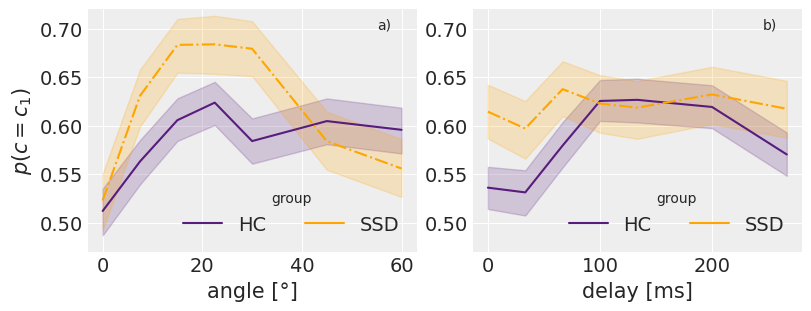

In [15]:
DATA = "post"

if DATA == "pre":
    plot_df = nested_model_data[nested_model_data["base_stim"] == 1].replace({"causal": 1, "non_causal":0})
    file_name = "figures/c1_props_interaction_pre.pdf"
elif DATA == "post":
    plot_df = nested_model_data[nested_model_data["base_stim"] == 2].replace({"causal": 1, "non_causal":0})
    file_name = "figures/c1_props_interaction_post.pdf"

# replace values for labelling as in paper and displaying ms instead of frames
plot_df["group"] = plot_df["group"].replace({-1: "HC", 1: "SSD"})
plot_df["delay"] = plot_df["delay"] * 1/60 * 1000

# create figure
fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs = axs.flatten()

colors = ["#581c7c", "orange"]
styles = ["-", "-."]

# main plot
p1 = sns.lineplot(data=plot_df, x="angle", y="same_answer", hue="group", palette=colors, ax=axs[0],
                  errorbar="ci")
p2 = sns.lineplot(data=plot_df, x="delay", y="same_answer", hue="group", palette=colors, ax=axs[1],
                  errorbar="ci")

# Styling

# change line styles:
for p in [p1, p2]:
    for line, style, handle in zip(p.lines, styles, p.legend_.legendHandles):
        line.set_linestyle(style)
        handle.set_ls(style)

# set axes limits and labels
for ax in axs:
    ax.set_ylim(0.47, 0.72)
    ax.set_ylabel("")
    ax.legend(title="group", ncols=2, loc="lower right")
# axs[1].get_yaxis().set_visible(False)
axs[0].set_ylabel("$p(c= c_1)$")
axs[0].set_xlabel("angle [°]")
axs[1].set_xlabel("delay [ms]")

# Add panel tags
axs[0].text(55, 0.7, "a)")
axs[1].text(245, 0.7, "b)")

print(f"Saving figure to {file_name}")
# plt.savefig(file_name)

## 3. Visualizing higher level interaction effects

Let's have a closer look at strong (> 0.1) interaction effects, namely
 Effect | Pre | Post 
 ---| ---| ---
$\alpha : c_1 : \alpha_1$ | 0.448 |0.352 
$\delta : c_1 : \delta_1$ | 0.266 |0.277 
$g : \alpha : c_1 : \alpha_1$ | 0.219 | 0.135
($g : \delta : c_1 : \delta_1$ | -0.016 | -0.0033)


3 and 4 way interactions of group x alpha x c1 x alpha1

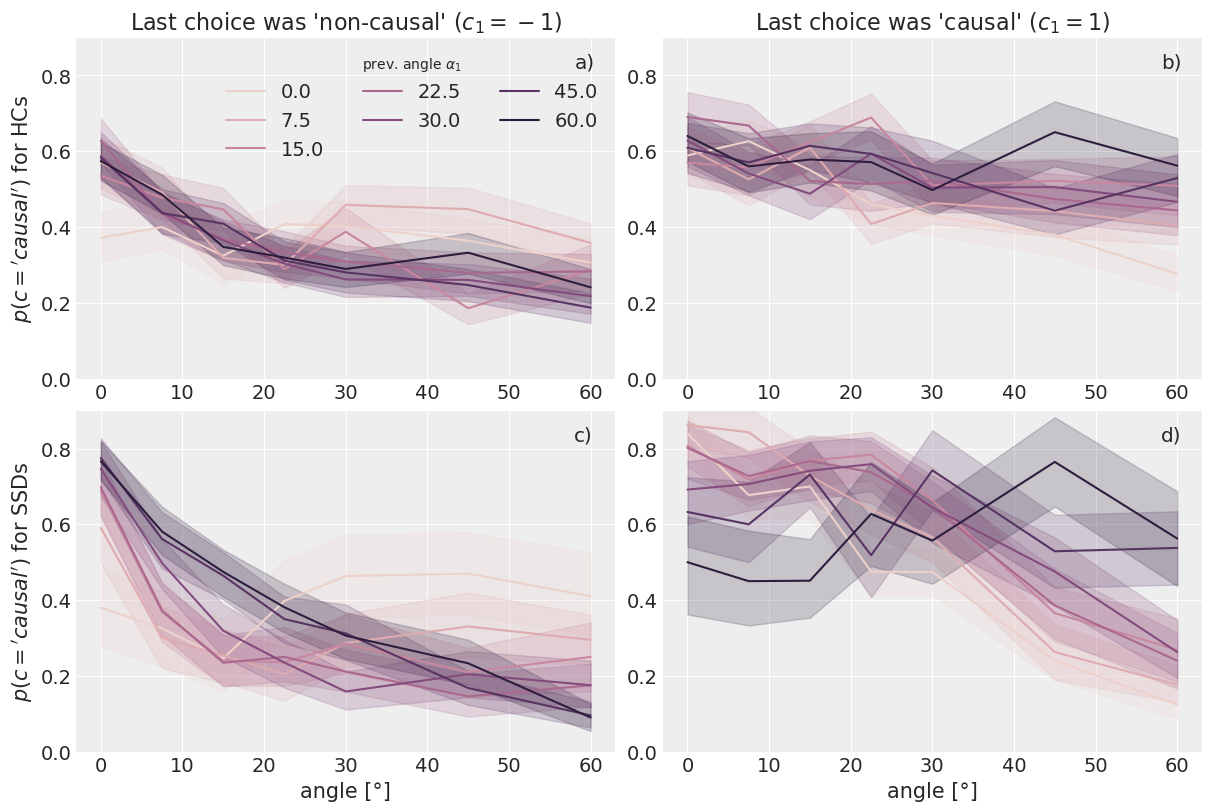

In [16]:
pltdf = nested_model_data.copy()
pltdf.loc[:, "c"] = pltdf.loc[:, "c"].replace({"non_causal": 0, "causal": 1})

a = pltdf[["c", "group", "c1", "angle", "angle1"]]
# b = a.groupby(["c1", "angle1", "angle"], group_keys=False).mean().reset_index()
# c = b[b["c1"] == -1]#.groupby(["angle", "angle1"], group_keys=False).mean().reset_index()

# make angle1 a factor 
a = a.sort_values(by="angle1")
a.loc[:, "angle1"] = a.loc[:, "angle1"].astype(str)
# specify coloring
colors_palette = sns.cubehelix_palette(len(a["angle1"].unique()))
sns.set_palette(colors_palette)

errorbar_style = "ci"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# HC
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == -1)], x="angle", y="c", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[0], 
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == -1)], x="angle", y="c", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[1], legend=False,
)

# SSD
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == 1)], x="angle", y="c", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[2], legend=False
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == 1)], x="angle", y="c", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[3], legend=False,
)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylim(0.0, 0.9)
    ax.set_ylabel("")

# x labels
axs[2].set_xlabel("angle [°]")
axs[3].set_xlabel("angle [°]")
# y labels
axs[0].set_ylabel("$p(c='causal')$ for HCs")
axs[2].set_ylabel("$p(c='causal')$ for SSDs")

# titles
axs[0].set_title("Last choice was 'non-causal' ($c_1 = -1$)")
axs[1].set_title("Last choice was 'causal' ($c_1 = 1$)")

# legend
axs[0].legend(ncol=3, title="prev. angle $\\alpha_1$")
# axs[1].legend(title="$g$ = 'HC'")
# axs[2].legend(title="$g$ = 'SSD'")
# axs[3].legend(title="$g$ = 'SSD'")

# add panel tags
axs[0].text(58, 0.82, "a)", {"fontsize": "x-large"})
axs[1].text(58, 0.82, "b)", {"fontsize": "x-large"})
axs[2].text(58, 0.82, "c)", {"fontsize": "x-large"})
axs[3].text(58, 0.82, "d)", {"fontsize": "x-large"})

plt.tight_layout()

# save
# plt.savefig("figures/g_x_c_x_a_a1-data_plot_mean_and_ci.eps", format='eps')
# plt.savefig("figures/g_x_c_x_a_a1-data_plot_mean_and_ci.pdf")
# plt.savefig("figures/g_x_c_x_a_a1-data_plot_mean_and_ci.png", dpi=1200)

3 (and 4) way interactions of group x delta x c1 x delta1

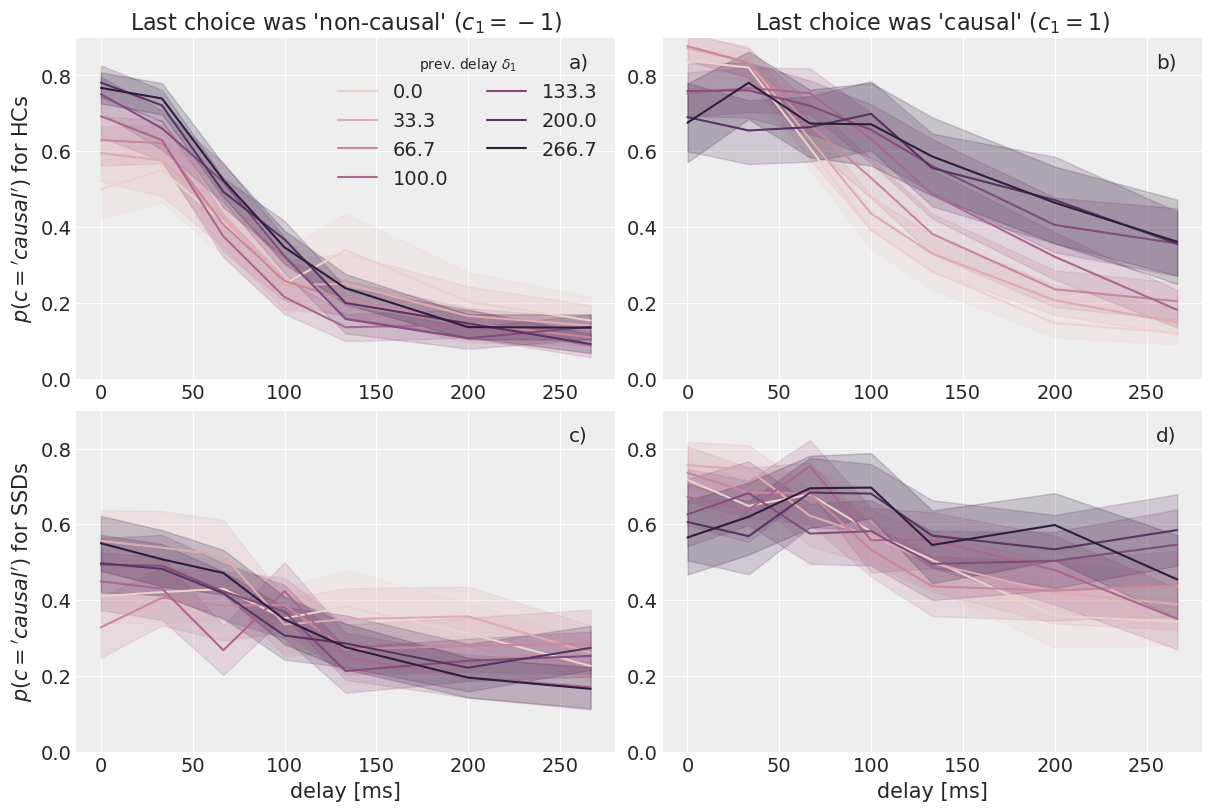

In [17]:
from matplotlib.patches import Patch

pltdf = nested_model_data.copy()
pltdf.loc[:, "c"] = pltdf.loc[:, "c"].replace({"non_causal": 0, "causal": 1})

a = pltdf[["c", "group", "c1", "delay", "delay1"]]

# scale delay to ms
a.loc[:, "delay"] = round(a.loc[:, "delay"] * 1/60 * 1000, 1)
a.loc[:, "delay1"] = round(a.loc[:, "delay1"] * 1/60 * 1000, 1)
# make delay1 a factor 
a = a.sort_values(by="delay1")
a.loc[:, "delay1"] = a.loc[:, "delay1"].astype(str)

# specify coloring
colors_palette = sns.cubehelix_palette(len(a["delay1"].unique()))
sns.set_palette(colors_palette)

errorbar_style = "ci"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# HC
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == -1)], x="delay", y="c", hue="delay1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[0],  
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == -1)], x="delay", y="c", hue="delay1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[1], legend=False,
)

# SSD
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == 1)], x="delay", y="c", hue="delay1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[2], legend=False
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == 1)], x="delay", y="c", hue="delay1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[3], legend=False,
)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylim(0.0, 0.9)
    ax.set_ylabel("")

# x labels
axs[2].set_xlabel("delay [ms]")
axs[3].set_xlabel("delay [ms]")
# y labels
axs[0].set_ylabel("$p(c='causal')$ for HCs")
axs[2].set_ylabel("$p(c='causal')$ for SSDs")

# titles
axs[0].set_title("Last choice was 'non-causal' ($c_1 = -1$)")
axs[1].set_title("Last choice was 'causal' ($c_1 = 1$)")

# coloring


# legend
patches = [Patch(label="1") for _ in range(6)]
axs[0].legend(ncol=2, title="prev. delay $\\delta_1$")
# axs[1].legend(title="$g$ = 'HC'")
# axs[2].legend(title="$g$ = 'SSD'")
# axs[3].legend(title="$g$ = 'SSD'")


# add panel tags
axs[0].text(255, 0.82, "a)", {"fontsize": "x-large"})
axs[1].text(255, 0.82, "b)", {"fontsize": "x-large"})
axs[2].text(255, 0.82, "c)", {"fontsize": "x-large"})
axs[3].text(255, 0.82, "d)", {"fontsize": "x-large"})

plt.tight_layout()

# save
# plt.savefig("figures/g_x_c_x_d_d1-data_plot_mean_and_ci.pdf")
# plt.savefig("figures/g_x_c_x_d_d1-data_plot_mean_and_ci.png", dpi=1200)

Plotting effects against "probability to repeat an answer (p(c = c1))"

In [18]:
# add "same_answer" column
idx_same = (nested_model_data["c1"] == nested_model_data["c"].replace({"causal": 1, "non_causal": -1}))
# add column to group:
nested_model_data.loc[:, "same_answer"] = 0
nested_model_data.loc[idx_same, "same_answer"] = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


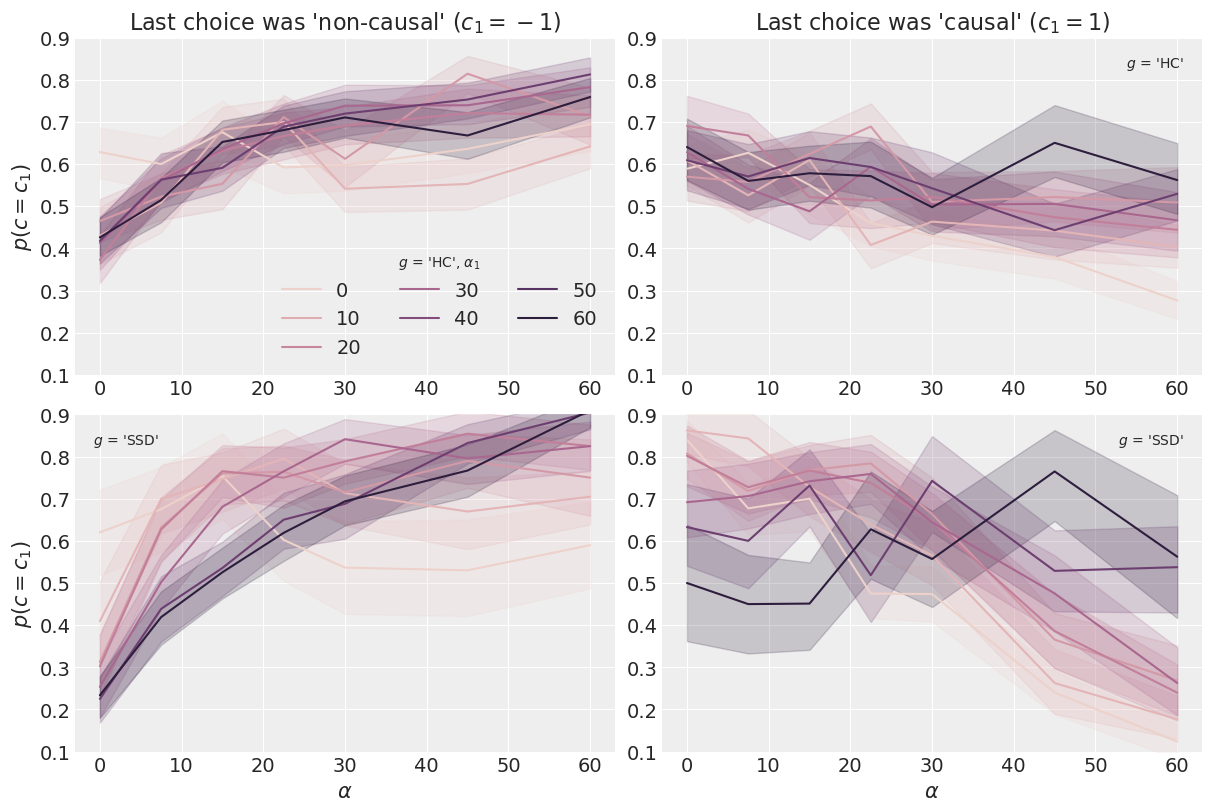

In [19]:
pltdf = nested_model_data.copy()
pltdf.loc[:, "c"] = pltdf.loc[:, "c"].replace({"non_causal": 0, "causal": 1})

a = pltdf[["c", "same_answer", "group", "c1", "angle", "angle1"]]

errorbar_style = "ci"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# HC
# HC
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == -1)], x="angle", y="same_answer", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[0], 
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == -1)], x="angle", y="same_answer", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[1], legend=False,
)

# SSD
sns.lineplot(a[(a["c1"] == -1) & (a["group"] == 1)], x="angle", y="same_answer", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[2], legend=False
)
sns.lineplot(a[(a["c1"] == 1) & (a["group"] == 1)], x="angle", y="same_answer", hue="angle1",
             estimator=np.mean, errorbar=errorbar_style,
             ax = axs[3], legend=False,
)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylim(0.1, 0.9)
    ax.set_ylabel("")

# x labels
axs[2].set_xlabel("$\\alpha$")
axs[3].set_xlabel("$\\alpha$")
# y labels
axs[0].set_ylabel("$p(c=c_1)$")
axs[2].set_ylabel("$p(c=c_1)$")

# titles
axs[0].set_title("Last choice was 'non-causal' ($c_1 = -1$)")
axs[1].set_title("Last choice was 'causal' ($c_1 = 1$)")

# legend
axs[0].legend(ncol=3, title="$g$ = 'HC', $\\alpha_1$")
axs[1].legend(title="$g$ = 'HC'")
axs[2].legend(title="$g$ = 'SSD'")
axs[3].legend(title="$g$ = 'SSD'")